In [ ]:
from langchain_openai import ChatOpenAI
from dotenv import dotenv_values
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from tavily import TavilyClient
config = dotenv_values(".env")
llm = ChatOpenAI(api_key=config["OPEN_AI_API_KEY"], model="gpt-4o-mini", temperature=0.1)

In [15]:
class AgentState(TypedDict):
   question: str
   context: str
   answer: str

In [16]:
def get_context(agentState: AgentState):
    client = TavilyClient(api_key=config["TAVILY_API_KEY"])
    response = client.search(
        query = agentState["question"],
        search_depth="advanced",       # "basic" | "advanced"
        topic="news",                  # boosts recent/news results
        max_age_days=14,               # recency window
        max_results=5,                 # number of sources to return
        include_answer=True,
        include_images=False,
        include_raw_content=False,
        include_domains=["reuters.com", "economictimes.indiatimes.com"],
        exclude_domains=[]
    )
    contexts = []
    for item in response:
        contexts.append(
            {
                'Title':response['results'][0]['title'],
                'Content':response['results'][0]['content']
            })
    agentState["context"] = contexts
    return agentState

def generate_answer(agentState: AgentState):
    prompt = f"""
    You are a helpful assistant. Answer the following question from the user.
    Question: {agentState["question"]}

    Your answer must be from the below context only, 
    If you do not find the answer in context mentioned you dont know 
    do not make up answer on your own

    Context: {agentState["context"]}
    """
    agentState["answer"] = llm.invoke(prompt)
    return agentState

In [17]:
workflow = StateGraph(AgentState)
workflow.add_node("RETRIVAL", get_context)
workflow.add_node("GENERATION", generate_answer)

workflow.add_edge(START, "RETRIVAL")
workflow.add_edge("RETRIVAL", "GENERATION")
workflow.add_edge("GENERATION",END)
graph = workflow.compile()

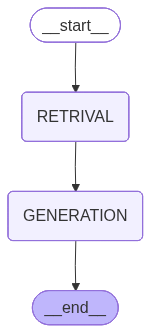

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
agentState : AgentState = {
    "question": "Is there a WAR bewtween Russia and Ukraine",
    "context": "",
    "answer": ""
}

agentState=graph.invoke(agentState)

In [22]:
print(agentState)

{'question': 'Is there a WAR bewtween Russia and Ukraine', 'context': [{'Title': 'US, Europe create military options on Ukraine, intend to present to national security advisers next - Reuters', 'Content': "Russia says it is engaged in a “special military operation” in Ukraine to protect its national security, claiming NATO’s eastward expansion and Western military support for Ukraine pose existential threats. Kyiv and its Western allies say the invasion is an imperial-style land grab.\n\nDespite Trump's push to end the war, Russia attacked a gas compressor station in eastern Ukraine that is important for getting gas into storage facilities for the winter heating season. [...] Reuters has previously reported that U.S. and European military planners have begun exploring post-conflict security guarantees for Ukraine, following President Donald Trump's pledge to help protect the country under any deal to end Russia's war in Ukraine.\n\nThe Reuters Daily Briefing newsletter provides all the